In [1]:
from sympy import *
from dtumathtools import *
from IPython.display import Markdown
from extras import print_delayer
import networkx as nx
init_printing(use_latex="mathjax" )
mdisplay = lambda x: display(Markdown(str(x)))
nx_args={'with_labels':True, 'node_color':"white", 'edgecolors':"black", 'node_size':400}

p = print_delayer()

# Grafteoretisk Modellering af Netværk

## Opgave 1

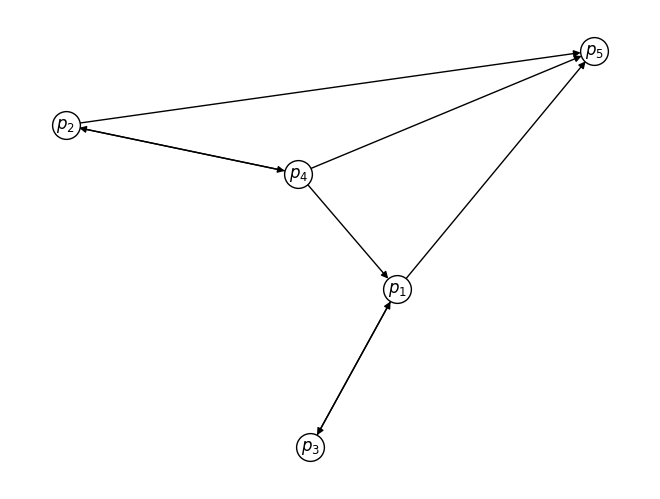

In [2]:
p1,p2,p3,p4,p5 = symbols('$p_1:6$')
V1 = {p1, p2, p3, p4, p5}
E1 = {(p1,p3), (p1,p5),(p2,p4),(p2,p5),(p3,p1),(p4,p1),(p4,p2),(p4,p5)}
W = nx.DiGraph()
W.add_nodes_from(V1, color="white")

W.add_edges_from(E1)
nx.draw(W,**nx_args)

## Opgave 2

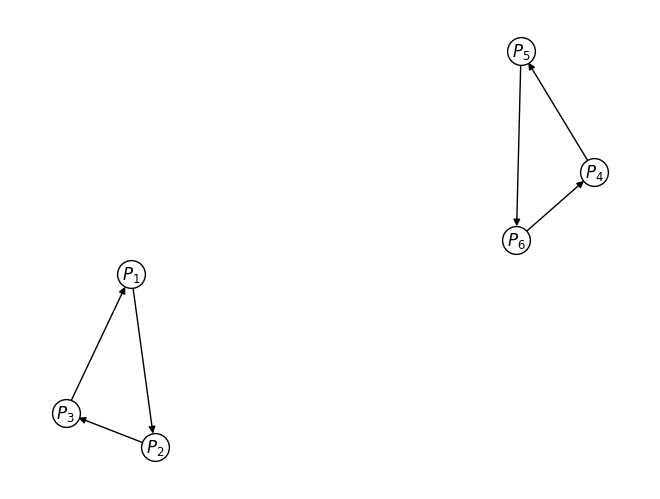

In [3]:
p1,p2,p3,p4,p5,p6 = symbols('$P_1:7$')
V2 = {p1, p2, p3, p4, p5, p6}
E2 = {(p1,p2), (p2,p3),(p3,p1),(p4,p5),(p5,p6),(p6,p4)}
W2 = nx.DiGraph()
W2.add_nodes_from(V2, color="white")

W2.add_edges_from(E2)
nx.draw(W2,**nx_args)

# Opgave 3
#

Jo flere komponenter der er i et netværk, jo svære bliver det at finde en specifik node. Faktisk er det helt umuligt at finde frem til en node i et komponent, hvis man er i et andet komponent til at begynde med. Der er altså ingen links fra den ene hjemmeside til den anden. 

##

In [4]:
W1 = {p1: {p3, p5}, p2: {p5, p4}, p3: {p1}, p4: {p1, p5, p2}, p5: {}}
W2 = {p1: {p2}, p2: {p3}, p3: {p1}, p4: {p5}, p5: {p6}, p6: {p4}}

Det kan tjekkes om en node i graphen ikke linker til andrer noder, ved at tjekke om nodens value i adjacency listen er den tomme mængde $\emptyset$

## Opgave 5

In [5]:
import numpy as np
import random

# Input: n og k er ikke-negative heltal
# Output: web er en dictionary med n nøgler.
# Værdien af hver nøgle er en liste, der er en delmængde af nøglerne.
def make_web(n,k,kmin=0):
    assert(k < n), "k skal være mindre end n (da man ikke kan linke til sig selv)"
    assert(kmin <= k), "kmin skal være mindre end eller lig med k"
    keys = list(symbols(f"$p_{{0:{n}}}$")) 
    web = dict()
    
    for i, j in enumerate(keys):
        numlinks = np.random.randint(kmin, k)
        
        
        # key_choices = keys.copy()
        # key_choices.remove(j)
        
        potential_pages = [ j ]
        
        while j in potential_pages:
            potential_pages = random.sample(keys, numlinks)
        
        web[j] = potential_pages
    
    return web

print(make_web(4,3, 1))

{$p_{0}$: [$p_{1}$, $p_{3}$], $p_{1}$: [$p_{2}$], $p_{2}$: [$p_{1}$], $p_{3}$: [$p_{1}$]}



## Opgave 6


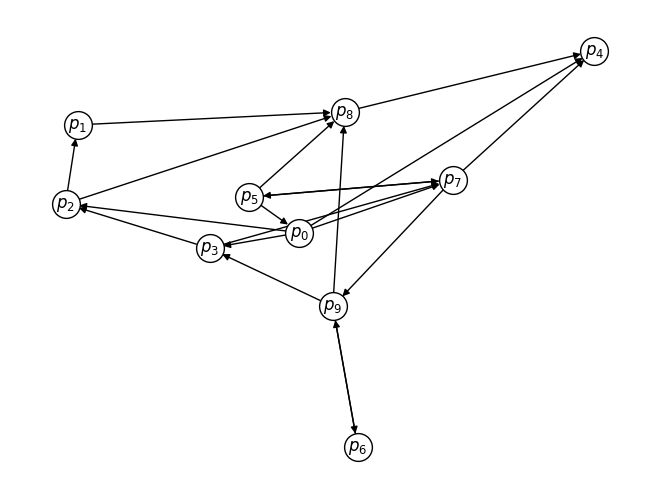

In [6]:
import matplotlib.pyplot as plt

def convert_to_nxgraph(web : dict):
    digraph = nx.DiGraph()
    digraph.add_nodes_from(web.keys())

    for page in web.keys():
        for link_to in web[page]:
            digraph.add_edge(page, link_to)

    return digraph

    # Input: netværk som dictionary
    # Output: Netværk visualiseret som graf
def visualize_graph(web : dict):
    digraph = convert_to_nxgraph(web)
    
    plt.figure()
    nx.draw(digraph, **nx_args)
    plt.plot()

visualize_graph(make_web(10, 5, 0))

# Link matricen og Random Surfer Modellen

## Opgave 7

In [7]:
def make_adjacency_matrix(graph):
    A = nx.adjacency_matrix(convert_to_nxgraph(graph))
    b = A.toarray().transpose()
    return b

In [8]:
W1 = {p1: {p3, p5}, p2: {p5, p4}, p3: {p1}, p4: {p1, p5, p2}, p5: {}}
display(Matrix(make_adjacency_matrix(W1)))




⎡0  0  1  1  0⎤
⎢             ⎥
⎢0  0  0  1  0⎥
⎢             ⎥
⎢1  0  0  0  0⎥
⎢             ⎥
⎢0  1  0  0  0⎥
⎢             ⎥
⎣1  1  0  1  0⎦

# Opgave 8

In [9]:
def make_link_matrix(graph: dict):

    adjacency_matrix : np.ndarray = make_adjacency_matrix(graph)

    n = adjacency_matrix.shape[0]
    link_matrix = np.zeros((n,n))
    for j in range(n):
        N = adjacency_matrix[:,j].sum()
        
        if N == 0:
            link_matrix[:,j] = 1 / n
            continue
            
        for i in range(n):
            if adjacency_matrix[i][j] == 1:
                link_matrix[i][j] = 1 / N
    
    return link_matrix
                

display(Matrix(make_link_matrix(W1)))


⎡0.0  0.0  1.0  0.333333333333333  0.2⎤
⎢                                     ⎥
⎢0.0  0.0  0.0  0.333333333333333  0.2⎥
⎢                                     ⎥
⎢0.5  0.0  0.0         0.0         0.2⎥
⎢                                     ⎥
⎢0.0  0.5  0.0         0.0         0.2⎥
⎢                                     ⎥
⎣0.5  0.5  0.0  0.333333333333333  0.2⎦

Matricerne har elementer samme sted, man tager antal 1-taller i hver søjle og sætter de tilsvarende elementer lig 1 / dette antal.
Hvis en søjle er en 0 vektor, sætter man alle elementer lig $\frac1N$

## Opgave 9

In [10]:
# Input: Et netværk som dictionary og en start side
# Output: Sandsynlighedsfordeling som dictionary for næste hjemmeside
def surf_step(web, page):
    
    distribution=dict()

    for link in web[page]:
        distribution[link] = 1 / len(web[page])
        
    if len(distribution) == 0:
        num_pages = len(web.keys())
        
        for web_page in web.keys():
            distribution[web_page] = 1 / num_pages

    return distribution

print(surf_step(W1, p1))

{$P_3$: 0.5, $P_5$: 0.5}


## Opgave 10

In [11]:
# Input: Et netværk som dictionary og antallet af skridt i random surf simuleringen
# Output: PageRank-værdier for hver side som en dictionary
def random_surf(web, n):


    
    ranking=dict()
    for page in web.keys():
        ranking[page] = 0
    page = np.random.choice(list(web.keys()))
    ranking[page] = 1
    
    
    for i in range(n-1):
        potential_pages = surf_step(web, page)
        page = np.random.choice(list(potential_pages.keys()), p = list(potential_pages.values()))
        ranking[page] += 1 
    for page in web.keys():
        ranking[page] /= n 
    return ranking
print(random_surf(W1,1000))

{$P_1$: 0.303, $P_2$: 0.086, $P_3$: 0.207, $P_4$: 0.1, $P_5$: 0.304}


## Opgave 11

In [12]:
def test_surf_model(model: callable, web: dict):
    output = ""
    for interval in [100, 1000, 10000]:
        output += f"interval: {interval}\n"
        for n in range(interval, interval+10, 1):
            output += f"{model(web, n)}\n"
    return output

In [13]:
mdisplay(p)

Den varierer meget, selv små skridt i iterations størrelsen varierer ret meget.
Størrelsesordnerne er dog ca. det samme, og den bliver mere konsistent desto højere skridt iterations størrelsen er.

## Opgave 12


In [14]:
import random

# Input: Et netværk som dictionary og en start side
# Output: Sandsynlighedsfordeling som dictionary for næste hjemmeside
def surf_step_damp(web, page, d):
    
    distribution=dict()

    for link in web[page]:
        distribution[link] = 1 / len(web[page])
    
    if len(distribution) == 0 or random.random() >= d:
        num_pages = len(web.keys())
        
        for web_page in web.keys():
            distribution[web_page] = 1 / num_pages

    return distribution

print(surf_step_damp(W1, p1, 0.85))

{$P_3$: 0.5, $P_5$: 0.5}


In [15]:
def random_surf_damp(web, iterations, d):


    
    ranking=dict()
    for page in web.keys():
        ranking[page] = 0
    page = np.random.choice(list(web.keys()))
    ranking[page] = 1
    
    
    for i in range(iterations-1):
        potential_pages = surf_step_damp(web, page, d)
        page = np.random.choice(list(potential_pages.keys()), p = list(potential_pages.values()))
        ranking[page] += 1 
    for page in web.keys():
        ranking[page] /= iterations 
    return ranking
print(random_surf_damp(W1,1000, 0.85))

{$P_1$: 0.282, $P_2$: 0.117, $P_3$: 0.207, $P_4$: 0.115, $P_5$: 0.279}


# Opgave 13

In [16]:
dampening_factor = 0.85


p.adisplay(test_surf_model(lambda web, n: random_surf_damp(web, n, dampening_factor), W1))




interval: 100

{$P_1$: 0.3, $P_2$: 0.09, $P_3$: 0.27, $P_4$: 0.11, $P_5$: 0.23}

{$P_1$: 0.2376237623762376, $P_2$: 0.1485148514851485, $P_3$: 0.2079207920792079, $P_4$: 0.16831683168316833, $P_5$: 0.2376237623762376}

{$P_1$: 0.23529411764705882, $P_2$: 0.12745098039215685, $P_3$: 0.14705882352941177, $P_4$: 0.13725490196078433, $P_5$: 0.35294117647058826}

{$P_1$: 0.27184466019417475, $P_2$: 0.1262135922330097, $P_3$: 0.21359223300970873, $P_4$: 0.1262135922330097, $P_5$: 0.2621359223300971}

{$P_1$: 0.22115384615384615, $P_2$: 0.14423076923076922, $P_3$: 0.15384615384615385, $P_4$: 0.17307692307692307, $P_5$: 0.3076923076923077}

{$P_1$: 0.22857142857142856, $P_2$: 0.1523809523809524, $P_3$: 0.12380952380952381, $P_4$: 0.18095238095238095, $P_5$: 0.3142857142857143}

{$P_1$: 0.27358490566037735, $P_2$: 0.12264150943396226, $P_3$: 0.19811320754716982, $P_4$: 0.08490566037735849, $P_5$: 0.32075471698113206}

{$P_1$: 0.2803738317757009, $P_2$: 0.11214953271028037, $P_3$: 0.205607476635514, $P_4$: 0.17757009345794392, $P_5$: 0.22429906542056074}

{$P_1$: 0.2777777777777778, $P_2$: 0.1111111111111111, $P_3$: 0.18518518518518517, $P_4$: 0.1574074074074074, $P_5$: 0.26851851851851855}

{$P_1$: 0.29357798165137616, $P_2$: 0.13761467889908258, $P_3$: 0.22018348623853212, $P_4$: 0.08256880733944955, $P_5$: 0.26605504587155965}

interval: 1000

{$P_1$: 0.295, $P_2$: 0.105, $P_3$: 0.202, $P_4$: 0.117, $P_5$: 0.281}

{$P_1$: 0.2777222777222777, $P_2$: 0.11288711288711288, $P_3$: 0.2047952047952048, $P_4$: 0.11788211788211789, $P_5$: 0.2867132867132867}

{$P_1$: 0.27245508982035926, $P_2$: 0.11676646706586827, $P_3$: 0.18862275449101795, $P_4$: 0.12075848303393213, $P_5$: 0.3013972055888224}

{$P_1$: 0.3090727816550349, $P_2$: 0.09471585244267199, $P_3$: 0.2313060817547358, $P_4$: 0.10468594217347957, $P_5$: 0.26021934197407776}

{$P_1$: 0.2699203187250996, $P_2$: 0.1145418326693227, $P_3$: 0.19621513944223107, $P_4$: 0.13545816733067728, $P_5$: 0.28386454183266935}

{$P_1$: 0.3044776119402985, $P_2$: 0.10248756218905472, $P_3$: 0.20497512437810944, $P_4$: 0.11741293532338308, $P_5$: 0.27064676616915423}

{$P_1$: 0.27137176938369784, $P_2$: 0.12027833001988071, $P_3$: 0.18687872763419483, $P_4$: 0.12226640159045726, $P_5$: 0.2992047713717694}

{$P_1$: 0.28798411122144985, $P_2$: 0.11022840119165839, $P_3$: 0.20655412115193644, $P_4$: 0.13108242303872888, $P_5$: 0.2641509433962264}

{$P_1$: 0.30257936507936506, $P_2$: 0.10218253968253968, $P_3$: 0.20734126984126985, $P_4$: 0.12698412698412698, $P_5$: 0.26091269841269843}

{$P_1$: 0.2804757185332012, $P_2$: 0.1110009910802775, $P_3$: 0.1952428146679881, $P_4$: 0.12091179385530228, $P_5$: 0.2923686818632309}

interval: 10000

{$P_1$: 0.2747, $P_2$: 0.1189, $P_3$: 0.1966, $P_4$: 0.1319, $P_5$: 0.2779}

{$P_1$: 0.28657134286571345, $P_2$: 0.10978902109789021, $P_3$: 0.20087991200879912, $P_4$: 0.128987101289871, $P_5$: 0.27377262273772623}

{$P_1$: 0.28224355128974205, $P_2$: 0.11037792441511697, $P_3$: 0.19976004799040192, $P_4$: 0.1261747650469906, $P_5$: 0.2814437112577485}

{$P_1$: 0.27941617514745576, $P_2$: 0.11286614015795261, $P_3$: 0.19374187743676896, $P_4$: 0.12576227131860443, $P_5$: 0.2882135359392182}

{$P_1$: 0.2828868452618952, $P_2$: 0.11235505797680928, $P_3$: 0.19622151139544183, $P_4$: 0.12425029988004799, $P_5$: 0.2842862854858057}

{$P_1$: 0.2762618690654673, $P_2$: 0.11814092953523238, $P_3$: 0.19400299850074962, $P_4$: 0.1313343328335832, $P_5$: 0.2802598700649675}

{$P_1$: 0.2869278432940236, $P_2$: 0.10703577853288027, $P_3$: 0.19938037177693385, $P_4$: 0.12342594443334, $P_5$: 0.2832300619628223}

{$P_1$: 0.27490756470470673, $P_2$: 0.11631857699610273, $P_3$: 0.1952633156790247, $P_4$: 0.12880983311681823, $P_5$: 0.28470070950334764}

{$P_1$: 0.2838729016786571, $P_2$: 0.11051159072741806, $P_3$: 0.1967426059152678, $P_4$: 0.11980415667466027, $P_5$: 0.2890687450039968}

{$P_1$: 0.2885403137176541, $P_2$: 0.10800279748226596, $P_3$: 0.19772205015486063, $P_4$: 0.12628634229193725, $P_5$: 0.27944849635328206}



Nu kan man se at man får et bedere estimat på pageranken for grafer med flere komponenter.

# Rekursiv Model og Matrix Formulering

## Opgave 14

\begin{equation*}
PR_{n+1}(p) = (1-d)\frac{1}{N} + d\sum_{q \in Inbound(p)}\frac{PR_n(q)}{\deg^+(q)} + \left[ d\sum_{s \in Sinks(W)}\frac{PR_{n}(s)}{N} \right]
\end{equation*}

Første led er sandsynligheden af at man kommer fra en tilfældig hjemmeside, hvor (1-d) er sandsynlighed for at dæmpningen sker. 1/N er sandsynlighen for at P sker. 
Andet led er sandsynlighedn for at man kommer (direkte) fra en anden hjemmeside (d). Ganget med for ethvert hjemmeside der peger på P (q), ganget med sandsynligheden for at man er på q, ganget med chancen for at man trykker på p. 

## Opgave 15

In [17]:
def rank_update(web: dict, page_ranks: dict, page, d):

        """
        Opdaterer værdien af PageRank for en side baseret på den rekursive formel
        Sider uden udgående links --->(sinks)<--- behandles som om de linker til alle sider på nettet.

        Input: 
            web og PageRanks er dictionaries som i outputtet fra "make_web" og "random_surf",
            page er nøglen til den side, hvis rank vi ønsker at opdatere, og
            d er dampingfaktoren.
        Output: 
            PageRank opdateres i henhold til ovenstående formel,
            og denne funktion returnerer et float "increment", den (absolutte) forskel
            mellem den tidligere værdi og den opdaterede værdi af PR(p).
        """
        # inbound_page is the same as q, in the original equation
        # lenth of web.keys is the same as N
        
        # for random pages
        new_page_rank = (1-d)* 1 / len(web)
        
        # for inbound web pages
        new_page_rank += d * sum([
              page_ranks[inbound_page]/len(web[inbound_page]) 
              for inbound_page in web 
              if page in web[inbound_page]
              ])
        
        # for sinks
        new_page_rank += d * sum([
              page_ranks[sink]/len(web) 
              for sink in web 
              if len(web[sink]) == 0
              ])

        return new_page_rank - page_ranks[page]

def recursive_page_rank(web : dict, iterations=200, stopvalue=0, d=0.85):
    """
    Implementerer den rekursive version af PageRank-algoritmen ved først at oprette
    en PageRank på 1/N til alle sider (hvor N er det samlede antal sider)
    og derefter anvende "rank_update" gentagne gange, indtil en af de to stopbetingelser
    er opnået:
    stopbetingelse 1: den maksimale ændring fra trin n til trin (n+1) over alle PageRank
    er mindre end stopværdien,
    Stopbetingelse 2: antallet af iterationer har nået "max_iterations".

    Input: web er et dictionary som i outputtet af "make_web", d er dæmpningen,
    stopvalue er et positivt float, max_iterations er et positivt heltal.
    """

    page_ranks = dict()
    
    for page in web:
        page_ranks[page] = 1/len(web)

    for iteration in range(iterations):
        increments = dict()
        
        for page in web:
            increments[page]=rank_update(web,page_ranks,page,d)
        
        if max([ abs(v) for v in increments.values()]) <= stopvalue:
            break
        
        for page in increments:
            page_ranks[page] += increments[page]

    return page_ranks


mdisplay(recursive_page_rank(W1, iterations=100, stopvalue=1e-6, d=1))


{$P_1$: 0.30232599878340827, $P_2$: 0.09302332921588996, $P_3$: 0.20930209908496478, $P_4$: 0.1046511985292208, $P_5$: 0.2906973743865164}

## Opgave 16

Argumentér for at (▲) kan omskrives til (■).

\begin{equation*}
PR_{n+1}(p) = (1-d)\frac{1}{N} + d\sum_{q \in Inbound(p)}\frac{PR_n(q)}{\deg^+(q)}
\end{equation*}

Vi kigger på række $i$ i matrix formlen

$$
x_{n+1} = (1-d) \frac{1}{N} \pmb{e} + d \pmb{L} {x_n}
\\
= (1-d) \frac{1}{N} \pmb{e} + d 
\begin{bmatrix}
\pmb{L}_{1,1} \cdot PR_{n}(p_0) + \pmb{L}_{1,2} \cdot PR_{n}(p_1) + \cdots + \pmb{L}_{1,N} \cdot PR_{n}(p_N) 
\\
\pmb{L}_{2,1} \cdot PR_{n}(p_0) + \pmb{L}_{2,2} \cdot PR_{n}(p_1) + \cdots + \pmb{L}_{2,N} \cdot PR_{n}(p_N)
\\
\vdots
\\
\pmb{L}_{N,1} \cdot PR_{n}(p_0) + \pmb{L}_{N,2} \cdot PR_{n}(p_1) + \cdots + \pmb{L}_{N,N} \cdot PR_{n}(p_N)
\end{bmatrix}
$$

I følge definitionen af link matricen vil alle elementer på række $i$ have værdi $\frac{1}{deg^+(p_j)}$ hvis den er inbound på $p_i$ og ellers $0$, altså passer det med summen i (▲)

$$
\pmb{x}_{n+1} =
\begin{bmatrix}
(1-d)\frac{1}{N}+d \sum_{j\in Inbound(p_{1})}\frac{PR_{n}(j)}{\deg^{+}(j)}
\\
(1-d)\frac{1}{N}+d \sum_{j\in Inbound(p_{2})}\frac{PR_{n}(j)}{\deg^{+}(j)}
\\
\vdots 
\\
(1-d)\frac{1}{N}+d \sum_{j\in Inbound(p_{n})}\frac{PR_{n}(j)}{\deg^{+}(j)}
\end{bmatrix}
$$

Her ses det hver række i $\pmb{x}_{n+1}$ stemmer overens med den rekursive formel (▲)

## Opgave 17

In [18]:
def modified_link_matrix(web: dict, d=0.85):

    # Input: web (dictionary), pagelist (liste over nøgler), d (dæmpningsfaktor)
    # Output: d*A^T + (1-d)*E/N
    
    # A: NxN numpy array, hvor række j har ikke-nul elementer i søjler, som side j linker til.
    # Hvis side j ikke linker til nogen, får alle elementer i række j værdien 1/N.
    # E: np.ones([N,N])
    
    # A er en Transponeret link-matrice ifølge formlen (BØR MÅSKE ÆNDRES)
    A = make_link_matrix(web).T
    N = len(web)
    
    E = np.ones([N,N])
    
    return d*A.T + (1-d)*E/N


In [19]:
Matrix(modified_link_matrix(W1)),Matrix(modified_link_matrix(W2))


⎛                                              ⎡0.025  0.025  0.875  0.025  0. ↪
⎜⎡0.03   0.03   0.88  0.313333333333333  0.2⎤  ⎢                               ↪
⎜⎢                                          ⎥  ⎢0.875  0.025  0.025  0.025  0. ↪
⎜⎢0.03   0.03   0.03  0.313333333333333  0.2⎥  ⎢                               ↪
⎜⎢                                          ⎥  ⎢0.025  0.875  0.025  0.025  0. ↪
⎜⎢0.455  0.03   0.03        0.03         0.2⎥, ⎢                               ↪
⎜⎢                                          ⎥  ⎢0.025  0.025  0.025  0.025  0. ↪
⎜⎢0.03   0.455  0.03        0.03         0.2⎥  ⎢                               ↪
⎜⎢                                          ⎥  ⎢0.025  0.025  0.025  0.875  0. ↪
⎜⎣0.455  0.455  0.03  0.313333333333333  0.2⎦  ⎢                               ↪
⎝                                              ⎣0.025  0.025  0.025  0.025  0. ↪

↪ 025  0.025⎤⎞
↪           ⎥⎟
↪ 025  0.025⎥⎟
↪           ⎥⎟
↪ 025  0.025⎥⎟
↪           ⎥⎟
↪ 025  0.875⎥⎟
↪  

## Opgave 18 [X]

Hver søjle i L summer til 1, det vil sige at hver søjle summer til d, efter som vi ganger den med d.

Hvis vi summer for $\frac{1-d}{N}\pmb{E}_N$, og da E er en N gange N matrice med 1, taller. Vil vi så få summen af en søjle til at være $(\frac{1-d}{N})N=1-d$

Da $d+(1-d)=1$ summer alle søjler altså til 1.


# Markov matricen: Egenskaber og Dæmpning i PageRank

## Opgave 19 [X]

Da link matricen ikke indeholder negative værdier og dens søjler summere til $1$, er dens transponerede matrix en markov matrix, da dens rækker nu summere til $1$.

## Opgave 20 [X]

Når vi ganger en markov matrix med en søjlevektor, bestående kun af 1 taller, vil det resultere i en søjlevektor hvor hvert element er summen af hver række i matricen. Da matricen er en markov matrix er summen af dens rækker alle $1$ altså det samme som vektoren der blev ganget på.

## Opgave 21 [X]

Diagonalen i $\pmb{A}$ og $\pmb{A}^T$ vil bestå af de samme værdier.
Dette må betyde deres karakteristiske polynomier er ens.
Dermed må deres egenværdier også være ens.

In [20]:
A = Matrix([
    [1, 2],
    [1, 2]
])

At = A.T

p.add(f"Eigenvects of $\\pmb{{A}}$: $${latex(A.eigenvects())}$$")
p.add(f"Eigenvects of $\\pmb{{A}}^T$: $${latex(At.eigenvects())}$$")
mdisplay(p)



Eigenvects of $\pmb{A}$: $$\left[ \left( 0, \  1, \  \left[ \left[\begin{matrix}-2\\1\end{matrix}\right]\right]\right), \  \left( 3, \  1, \  \left[ \left[\begin{matrix}1\\1\end{matrix}\right]\right]\right)\right]$$

Eigenvects of $\pmb{A}^T$: $$\left[ \left( 0, \  1, \  \left[ \left[\begin{matrix}-1\\1\end{matrix}\right]\right]\right), \  \left( 3, \  1, \  \left[ \left[\begin{matrix}\frac{1}{2}\\1\end{matrix}\right]\right]\right)\right]$$

## Opgave 22 

Hver række i $A$ summer til $1$, det vil sige at hver række summer til $d$, efter som vi ganger den med $d$.

Hvis vi summer for $\frac{1-d}{n}\pmb{E}_n$, og da $E$ er en $n$ gange $n$ matrice med $1$, taller. Vil vi så få summen af en række til at være $(\frac{1-d}{n})n=1-d$

Da $d+(1-d)=1$ summer alle rækker altså til 1.

Der er ingen negative elementer i hverken højre eller venstre led. Ledet til venstre KAN ikke være 0, og da d ikke kan være 1 ender venstre udtryk altså med at være strengt positivt. A, kan godt have elementer som er 0, men da venstre udtryk altid er positivt, vil vores $\pmb{A}_d$ matrix stadig være strengt positiv.


## Opgave 23

Grundet opgave 18, ved vi at $\pmb{M}_d$'s søjler summer til 1, ud fra opgave 19 ved vi så at $\pmb{M}_d$ transporneret er en markov matrix.
Vi ved så ud fra opgave 20 at en markov matrix altid har egenværdi 1, og ud fra opgave 21 ved vi at den transpornerede version af en matrix har samme egenværdier som den ikke transpornerede. Derfor må $\pmb{M}_d$ altså have egenværdien 1. 

## Opgave 24

In [21]:
from scipy.linalg import null_space

def eigenvector_PageRank(web :dict,d=0.85):
        # Input: web er en ordbog over websider og links.
        # d er dæmpningen
        # Output: En ordbog med de samme nøgler som web og værdierne er PageRank for nøglerne

        ranking = dict()

        # INDSÆT KODE HER
        
        Md = modified_link_matrix(web, d)
        
        eig_mat = (Md - np.eye(len(web)))

        # første egenvektor har egenværdi 1

        probability_vector = null_space(eig_mat, rcond=0.0000001)
        probability_vector /= sum(probability_vector)
        for page, pagerank in zip(web, probability_vector):
            ranking[page] = pagerank[0]

        return ranking

print(eigenvector_PageRank(W1))

{$P_1$: 0.2814079026123765, $P_2$: 0.11357982853189831, $P_3$: 0.19744479303585655, $P_4$: 0.12611786155165336, $P_5$: 0.28144961426821513}


## Opgave 25

In [22]:
from time import time
start_time = time()
print("BEFORE WEB")
web = make_web(500, 10, 0)
print("AFTER WEB")
print(eigenvector_PageRank(web))
print("AFTER PAGE RANK")
print(time() - start_time)

BEFORE WEB
AFTER WEB
{$p_{0}$: 0.0011452125382834539, $p_{1}$: 0.002867012257105078, $p_{2}$: 0.0008774987669544408, $p_{3}$: 0.0012138427530117165, $p_{4}$: 0.0023338216841433195, $p_{5}$: 0.002053381434092914, $p_{6}$: 0.002468770044761935, $p_{7}$: 0.003191655068756647, $p_{8}$: 0.003011508021797262, $p_{9}$: 0.001294627126739396, $p_{10}$: 0.0021644013019148705, $p_{11}$: 0.0009942281467807143, $p_{12}$: 0.003416473846266011, $p_{13}$: 0.003659625342752931, $p_{14}$: 0.0041943435132365805, $p_{15}$: 0.00256416503897422, $p_{16}$: 0.0017668783113985779, $p_{17}$: 0.0012445669255896831, $p_{18}$: 0.0017730474273976518, $p_{19}$: 0.001973100396351498, $p_{20}$: 0.001836061103249243, $p_{21}$: 0.0014729041979092898, $p_{22}$: 0.0019987465157389607, $p_{23}$: 0.0010548626035898417, $p_{24}$: 0.0026820201404684652, $p_{25}$: 0.006352021850006346, $p_{26}$: 0.001131752537804104, $p_{27}$: 0.002231055894358749, $p_{28}$: 0.001302759592911149, $p_{29}$: 0.0014761144162360894, $p_{30}$: 0.00

# PageRank algoritmen: Iterativ Konvergens og Dæmpning i Markov Matricer

# Opgave 26


In [23]:
A = Matrix([
    [0.2, 0.5, 0.3],
    [0.4, 0.4, 0.2],
    [0.1, 0.7, 0.2],
])

B = Matrix([
    [0.5, 0.3, 0.2],
    [0.2, 0.5, 0.3],
    [0.3, 0.2, 0.5],
])

C : Matrix = A*B
def is_markov(matrix : Matrix):
    for row in range(matrix.rows):
        if (sum(matrix.row(row)) not in [1, 1.0]):
            return False

    return True
p.add(C)
p.adisplay(f"${latex(is_markov(C))}$")



$\left[\begin{matrix}0.29 & 0.37 & 0.34\\0.34 & 0.36 & 0.3\\0.25 & 0.42 & 0.33\end{matrix}\right]$

$\text{True}$

# Opgave 27

Summen af en række $i$ af en matrix som er produktet af 2 matricer er kan beskrives som:
$$
a_{i1}(b_{11}+\dots+b_{1n})+a_{i2}(b_{21}+\dots +b_{2n})+\dots +a_{in}(b_{n1}+\dots+b_{nn})
$$

altså det første element i den givne række i den første matrice skal ganges med alle elementer i den anden matrices første række, det skal plusses med andet element i den givne række til den første matrice ganget med alle elementer i den anden matrices anden række osv.

Hvis man summere alle rækkerne så får man altså denne søjlevektor, hvor hvert element er summen til den korrosponderene række.
$$
\begin{bmatrix}
a_{11}(b_{11}+\dots+b_{1n})+a_{12}(b_{21}+\dots +b_{2n})+\dots +a_{1n}(b_{n1}+\dots+b_{nn}) \\
a_{21}(b_{11}+\dots+b_{1n})+a_{22}(b_{21}+\dots +b_{2n})+\dots +a_{2n}(b_{n1}+\dots+b_{nn}) \\
\vdots \\
a_{n1}(b_{11}+\dots+b_{1n})+a_{n2}(b_{21}+\dots +b_{2n})+\dots +a_{nn}(b_{n1}+\dots+b_{nn}) \\
\end{bmatrix}
$$

Det kan vi skrive om eftersom vi ved at summen af rækkerne i de originalle matricer er 1, da de er markov matricer.

$$
\begin{bmatrix}
a_{11}(1)+a_{12}(1)+\dots +a_{1n}(1) \\
a_{21}(1)+a_{22}(1)+\dots +a_{2n}(1) \\
\vdots \\
a_{n1}(1)+a_{n2}(1)+\dots +a_{nn}(1) \\
\end{bmatrix}=
\begin{bmatrix}
a_{11}+a_{12}+\dots +a_{1n} \\
a_{21}+a_{22}+\dots +a_{2n} \\
\vdots \\
a_{n1}+a_{n2}+\dots +a_{nn} \\
\end{bmatrix}
=\begin{bmatrix}
1 \\
1 \\
\vdots \\
1
\end{bmatrix}
$$

# Opgave 28


Hvis produktet af 2 markov matricer er en markov matrix, så må $A^K$ også være en markov matrix.

# Opgave 29

$$
\pmb{A} \cdot \pmb{v} = 
\begin{bmatrix}
a_{11} & \cdots & a_{1n} \\
 & \vdots &  \\
a_{n1} & \cdots & a_{nn} \\
\end{bmatrix}
\cdot
\begin{bmatrix}
v_1 \\
\vdots \\
v_n \\
\end{bmatrix}
=
\begin{bmatrix}
v_1 \cdot a_{11} + \cdots + v_n \cdot a_{1n} \\
\vdots \\
v_1 \cdot a_{n1} + \cdots + v_1 \cdot a_{nn} \\
\end{bmatrix}
$$
Da $\pmb{A}$ er en markov matrix, må dens rækker summe til $1$. Dette medfører at hvert koordinat i $\pmb{A} \cdot \pmb{v}$ vil være et vægtet gennemsnit af alle elementer i $v$.
Da normen af et vægtet gennemsnit af komplekse tal aldrig kan antage en værdi større end den største norm i gennemsnittet, må det betyde der ikke kan eksisterer en værdi i $\pmb{A} \cdot \pmb{v}$, hvis norm er større end den største norm i $\pmb{v}$.


Antag nu at $|\lambda| > 1$.
Givet rækken $i$ indeholder den største norm i $v$, må rækken $i$ i $\pmb{A} \cdot \pmb{v}$ antage værdien $\lambda \cdot v_i$,.
Normen vil derfor være lig $|\lambda| \cdot |\pmb{v}_i|$ i $\pmb{A} \cdot \pmb{v}$, hvilket er en modstrid med det overstående.
Dermed må $|\lambda| \leq 1$.
Det er tidligere vist at en markov matrix altid har en egen værdi lig $1$.
Det må derfor være garanteret at $\mathrm{rad}_{\pmb{A}} = 1$

# Opgave 30 (*)

In [24]:
A = Matrix([
    [0, 1, 0],
    [0, 0, 1],
    [1, 0, 0],
])
p.add(is_markov(A))

p.add(A.eigenvals())

p.add(A**2)
p.add(A**1000)
p.add(A**1001)
mdisplay(p)




$\text{True}$

$\left\{ 1 : 1, \  - \frac{1}{2} - \frac{\sqrt{3} i}{2} : 1, \  - \frac{1}{2} + \frac{\sqrt{3} i}{2} : 1\right\}$

$\left[\begin{matrix}0 & 0 & 1\\1 & 0 & 0\\0 & 1 & 0\end{matrix}\right]$

$\left[\begin{matrix}0 & 1 & 0\\0 & 0 & 1\\1 & 0 & 0\end{matrix}\right]$

$\left[\begin{matrix}0 & 0 & 1\\1 & 0 & 0\\0 & 1 & 0\end{matrix}\right]$

# Opgave 31

Da $\lvert \lambda \rvert=1$ kan vi sige at

$$
\lVert \pmb{v} \rVert_{\infty}=\lvert v_{k} \rvert =\lvert \lambda \rvert \lvert v_{k} \rvert 
$$

Fra (Theorem 3.6.2) fra mat1a lærer bog ved vi at $\lvert z \rvert \lvert w \rvert = \lvert z\cdot w \rvert$ for vilkårlige $z,w\in\mathbb{C}\backslash\{ 0 \}$
Dermed ved vi at
$$
\begin{align}
\lvert \lambda \rvert \lvert v_{k} \rvert =\lvert \lambda v_{k} \rvert  \\

\end{align}
$$
noget noget
idk 
$$
\left\lvert  \sum_{j=1}^{n}a_{kj}v_{j}  \right\rvert 
$$

Trekantsuligheden siger at summen af normen af alle de individuelle led er større end eller ligmed normen af summen. Altså:

$$
\left\lvert  \sum_{j=1}^{n}a_{kj}v_{j}  \right\rvert \leq\sum_{j?1}^{n}\lvert a_{kj}v_{j} \rvert 
$$
Det kan vi videre omskrive vha.  tidligere teori og at vi ved at alle det gælder for alle elementer $0<a_{kj}<1$


$$
\sum_{j=1}^{n}\lvert a_{kj}v_{j} \rvert =\sum_{j=1}^{n}\lvert a_{kj}\rvert  \lvert v_{j} \rvert=\sum_{j=1}^{n} a_{kj}  \lvert v_{j} \rvert
$$

Da $\lvert v_{j} \rvert$ højest kan være $\lVert \pmb{v} \rVert_{\infty}$ kan vi sige:

$$
\sum_{j=1}^{n} a_{kj}  \lvert v_{j} \rvert\leq\sum_{j=1}^{n} a_{kj}  \lVert \pmb{v} \rVert_{\infty}
$$

Det kan vi til sidst omskrive således:

$$
\sum_{j=1}^{n} a_{kj}  \lVert \pmb{v} \rVert_{\infty}=\lVert \pmb{v} \rVert_{\infty}\sum_{j=1}^{n} a_{kj}  =\lVert \pmb{v} \rVert_{\infty}\cdot(1)=\lVert \pmb{v} \rVert_{\infty}
$$


Da alle $v_j$ er ens, må det betyde $v$ er udspændt af $\pmb{e}$.
Da $\pmb{e}$ har tilhørende egenværdi $1$, må ethvert $|\lambda| = 1$ medfører at $\lambda = 1$.

In [25]:
A = Matrix([
    [0.2, 0.5, 0.3],
    [0.4, 0.4, 0.2],
    [0.1, 0.7, 0.2],
])

B = Matrix([
    [0.5, 0.3, 0.2],
    [0.2, 0.5, 0.3],
    [0.3, 0.2, 0.5],
])

p.add(A.eigenvects())
p.adisplay(B.eigenvects())




$\left[ \left( 1.0 + 1.04082971799209 \cdot 10^{-33} i, \  1, \  \left[ \left[\begin{matrix}0.471433701802153 - 0.333292061319276 i\\0.471433701802153 - 0.333292061319276 i\\0.471433701802153 - 0.333292061319276 i\end{matrix}\right]\right]\right), \  \left( -0.1 - 0.141421356237309 i, \  1, \  \left[ \left[\begin{matrix}-0.24771821020657 - 0.336797322286762 i\\0.413847007681092 - 0.0871346248703274 i\\-0.600794582911543 + 0.598797181244281 i\end{matrix}\right]\right]\right), \  \left( -0.1 + 0.141421356237309 i, \  1, \  \left[ \left[\begin{matrix}0.161676632563345 + 0.485855728003897 i\\0.379737811419842 - 0.352266770367143 i\\-1.023607571563 + 0.177470651437973 i\end{matrix}\right]\right]\right)\right]$

$\left[ \left( 1.0 - 8.66498388741215 \cdot 10^{-66} i, \  1, \  \left[ \left[\begin{matrix}-0.543365203902173 + 0.195160417404974 i\\-0.543365203902173 + 0.195160417404974 i\\-0.543365203902173 + 0.195160417404974 i\end{matrix}\right]\right]\right), \  \left( 0.25 - 0.0866025403784439 i, \  1, \  \left[ \left[\begin{matrix}0.357960639322653 - 0.452987322150467 i\\-0.571278848235916 - 0.0835093461331033 i\\0.213318208913263 + 0.53649666828357 i\end{matrix}\right]\right]\right), \  \left( 0.25 + 0.0866025403784439 i, \  1, \  \left[ \left[\begin{matrix}0.547323372506061 - 0.183767405276141 i\\-0.114514444896342 + 0.565879647313292 i\\-0.432808927609719 - 0.382112242037151 i\end{matrix}\right]\right]\right)\right]$

## Opgave 32 (*)

In [26]:
A = Matrix([
    [0, 1, 0],
    [0, 0, 1],
    [1, 0, 0],
])
d = 0.85
iterations = A.shape[0]
En = Matrix(np.ones([iterations,iterations]))
Ad = (1-d)/iterations*En+d*A

p.add(Ad)
p.add(Ad.eigenvals())
p.add([abs(val) for val in Ad.eigenvals()])
p.add(Ad**2)
p.add(Ad**1000)
p.add(Ad**1001)
mdisplay(p)




$\left[\begin{matrix}0.05 & 0.9 & 0.05\\0.05 & 0.05 & 0.9\\0.9 & 0.05 & 0.05\end{matrix}\right]$

$\left\{ -0.425 - 0.736121593216773 i : 1, \  -0.425 + 0.736121593216773 i : 1, \  1.0 + 5.1434798388906 \cdot 10^{-66} i : 1\right\}$

$\left[ 1.0, \  0.85, \  0.85\right]$

$\left[\begin{matrix}0.0925 & 0.0925 & 0.815\\0.815 & 0.0925 & 0.0925\\0.0925 & 0.815 & 0.0925\end{matrix}\right]$

$\left[\begin{matrix}0.333333333333343 & 0.333333333333343 & 0.333333333333343\\0.333333333333343 & 0.333333333333343 & 0.333333333333343\\0.333333333333343 & 0.333333333333343 & 0.333333333333343\end{matrix}\right]$

$\left[\begin{matrix}0.333333333333343 & 0.333333333333343 & 0.333333333333343\\0.333333333333343 & 0.333333333333343 & 0.333333333333343\\0.333333333333343 & 0.333333333333343 & 0.333333333333343\end{matrix}\right]$

Wow, det passer med at den absolutte værdi af en af egenværdierne er præcist 1. Alle andre har modulus mindre end 1. Den konvergere også imod en specifik matrice, når k går mod uenedeligt.

## Opgave 33

Fordi at det betyder vores Markov matrice opløftet i k, konvergere mod én bestemt matrice. Altså er der en entydig løsning til PageRank algoritmen.

## Opgave 34

$$(A^T)^k=VDV^{-1} \dots VDV^{-1} = VD^k V^{-1}$$
Da $D$ er den diagonaliserede matrix, betyder det at dén, ganget med en anden diagonaliseret matrice, såsom den selv, vil betyde de diagonale elemnter blot ganges med hinanden. Dette vil altså sige at $D^k$ gør at hvert diagonale element opløftes i $k$, for den diagonale matrice.
D består af egenværdierne for $A$, her bør en af egenværdierne være 1, og resten være modulus under 1. Dette vil betyde at jo mere man opløfter $D$ i, jo mere vil alle egenværdier gå mod 0, bortset fra den ene egenværdi som var 1, som stadig vil forblive 1.

Dette betyder altså at $D$ konvergere, og hermed må vores $A$ altså også konvergere, da V og $V^{-1}$ er konstante

## Opgave 35

In [27]:

# Input: web er et dictionary med websider og links.
# d er en positiv float, dæmpningskonstanten.
# Output: Et dictionary med de samme nøgler som web, og værdierne er PageRank for hver nøgle.

def matrix_PageRank(web,iterations,d=0.85):
    ranking = dict()    

    A = modified_link_matrix(web,d)
    A2 = A.copy()
    for i in range(iterations):
        A2 = np.matmul(A2,A)
 
            
    probability_vector = A2[:,0]

    for page, pagerank in zip(web, probability_vector):
        ranking[page] = pagerank

    return ranking



In [28]:
p.add(f"{matrix_PageRank(W1,100)}")
mdisplay(p)
# print()



{$P_1$: 0.28140790261237736, $P_2$: 0.11357982853189882, $P_3$: 0.1974447930358571, $P_4$: 0.12611786155165378, $P_5$: 0.2814496142682163}

In [29]:
p.add(f"{matrix_PageRank(W1,10000, 0.85)}")
p.add(f"{matrix_PageRank(W1,10000, 0.75)}")
p.add(f"{matrix_PageRank(W1,10000, 0.2)}")
mdisplay(p)



{$P_1$: 0.28140790261237736, $P_2$: 0.11357982853189882, $P_3$: 0.1974447930358571, $P_4$: 0.12611786155165378, $P_5$: 0.2814496142682163}

{$P_1$: 0.2698716197760177, $P_2$: 0.1256487298552309, $P_3$: 0.19229718656104902, $P_4$: 0.13821360284075412, $P_5$: 0.2739688609669495}

{$P_1$: 0.21948286229705366, $P_2$: 0.18132198529071664, $P_3$: 0.1908043850316853, $P_4$: 0.18698829733105152, $P_5$: 0.22140247004949368}

In [30]:
p.add(Matrix(modified_link_matrix(W1, 1)).eigenvects())
p.add(Matrix(modified_link_matrix(W1, 0.85)).eigenvects())
p.add(Matrix(modified_link_matrix(W1, 0.75)).eigenvects())
mdisplay(p)



$\left[ \left( 1.0, \  1, \  \left[ \left[\begin{matrix}0.617997495103987\\0.190153075416611\\0.427844419687376\\0.213922209843688\\0.59422836067691\end{matrix}\right]\right]\right), \  \left( 0.505338803307367, \  1, \  \left[ \left[\begin{matrix}-0.603171868084345\\0.408593461539158\\-0.511284280899825\\0.489791950533077\\0.216070736911936\end{matrix}\right]\right]\right), \  \left( -0.657327022405595, \  1, \  \left[ \left[\begin{matrix}0.763606063750391\\0.133979929727643\\-0.413870271905919\\0.0650588703333036\\-0.548774591905419\end{matrix}\right]\right]\right), \  \left( -0.392053344702297, \  1, \  \left[ \left[\begin{matrix}-0.518396821282965\\0.479444727505116\\0.391207116685288\\-0.881376783275808\\0.52912176036837\end{matrix}\right]\right]\right), \  \left( -0.255958436199475, \  1, \  \left[ \left[\begin{matrix}0.48102625682082\\0.168305576536553\\-0.080043496292797\\0.53083826429226\\-1.10012660135684\end{matrix}\right]\right]\right)\right]$

$\left[ \left( 1.0, \  1, \  \left[ \left[\begin{matrix}0.591690982326455\\0.238814047838163\\0.415149334692108\\0.265176637534584\\0.591778685658126\end{matrix}\right]\right]\right), \  \left( 0.429537982811262, \  1, \  \left[ \left[\begin{matrix}-0.593448365740731\\0.402006683058458\\-0.503042063106459\\0.48189620235434\\0.212587543434392\end{matrix}\right]\right]\right), \  \left( -0.558727969044756, \  1, \  \left[ \left[\begin{matrix}0.762913952863417\\0.133858494117841\\-0.413495151625216\\0.0649999028177358\\-0.548277198173778\end{matrix}\right]\right]\right), \  \left( -0.333245342996952, \  1, \  \left[ \left[\begin{matrix}-0.518388583966927\\0.479437109137138\\0.391200900411336\\-0.881362778214792\\0.529113352633245\end{matrix}\right]\right]\right), \  \left( -0.217564670769554, \  1, \  \left[ \left[\begin{matrix}0.478260825480777\\0.167337983791961\\-0.0795833243373664\\0.527786462541831\\-1.0938019474772\end{matrix}\right]\right]\right)\right]$

$\left[ \left( 1.0, \  1, \  \left[ \left[\begin{matrix}0.57568436513911\\0.268031182149788\\0.410204243985763\\0.294834300364767\\0.584424512383125\end{matrix}\right]\right]\right), \  \left( 0.379004102480525, \  1, \  \left[ \left[\begin{matrix}-0.5893339435449\\0.399219540460831\\-0.499554434612785\\0.478555179705169\\0.211113657991685\end{matrix}\right]\right]\right), \  \left( -0.492995266804196, \  1, \  \left[ \left[\begin{matrix}0.762558552947153\\0.133796136760995\\-0.413302526832194\\0.0649696229153537\\-0.548021785791308\end{matrix}\right]\right]\right), \  \left( -0.294040008526723, \  1, \  \left[ \left[\begin{matrix}-0.5183851981559\\0.479433977734362\\0.391198345315867\\-0.881357021668631\\0.529109896774302\end{matrix}\right]\right]\right), \  \left( -0.191968827149607, \  1, \  \left[ \left[\begin{matrix}0.476707204190304\\0.166794389500995\\-0.0793247994060534\\0.526071958151462\\-1.09024875243671\end{matrix}\right]\right]\right)\right]$

## Opgave 37

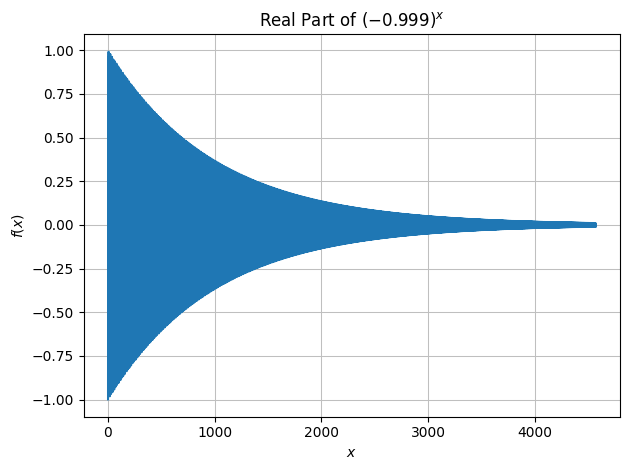

In [31]:
from dtumathtools import *

x = symbols('x')
f = (-0.999)**x

plot = dtuplot.plot(re(f), (x, 1, 4567), n = 10000, title=f'Real Part of ${latex(f)}$', show=False)
plot.show()

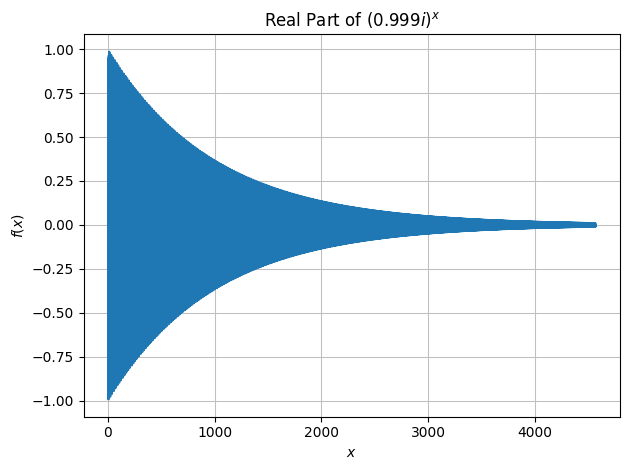

In [32]:
f = (0.999 * I)**x

plot = dtuplot.plot(re(f), (x, 1, 4567), n = 10000, title=f'Real Part of ${latex(f)}$', show=False)
plot.show()

De konvergere meget langsomt.

# Analyse af PageRank Modeller og Undersøgelse af Dæmpning

## Opgave 38

vi kan tillade os at bruge den fordi den konvenger, og fordi det den konvengerer imod er approksimativt det samme som random surfs PageRanking.

## Opgave 39

In [33]:
import matplotlib.pyplot as plt



    # Input: web og ranking er dictionary, eksempelvis som output fra funktionerne "make_web" og "random_surf".

    # Output: Grafisk repræsentation af webstrukturen med links som #pile og PageRank visualiseret ved størrelsen af hjemmesider.


def plot_ranking(web : dict, ranking, d=0.85):
    digraph = nx.DiGraph()


    digraph.add_nodes_from(web.keys())

    
    #     G.add_nodes_from([(4, {"color": "red"}), (5, {"color": "green"})])

    node_list = list(web.keys())
    node_sizes = [ ranking[page] * 10000 for page in web.keys()]

    for page in web.keys():
        p.add(ranking[page]*200)
        for link_to in web[page]:
            digraph.add_edge(page, link_to)
    # mdisplay(p)


    nx_args={'with_labels':True, 'node_color':"white", 'edgecolors':"black"}
    pos = nx.spring_layout(digraph, 1.5)
    nx.draw(digraph, pos, node_size=node_sizes, **nx_args)

W = make_web(5000, 500, 0)
# plot_ranking(W, matrix_PageRank(W, 100))


## Opgave 40

In [34]:
import math

def fiddle(web: dict, max_error: float, d: float, pagerank_algorithms: list):
    expected_pageranks = eigenvector_PageRank(web, d=d)
    print("COMPUTED TABLE VALUE")

    fiddle_dict = {}

    for algorithm in pagerank_algorithms:
        current_error = max_error + 1
        iteration_count = 1
        while current_error > max_error:
            iteration_count *= 1.3
            pagerank = algorithm(web = web, iterations = math.floor(iteration_count), d = d)

            current_error = 0

            for page in expected_pageranks:
                error = abs(expected_pageranks[page] - pagerank[page])
                if error > current_error:
                    current_error = error
        fiddle_dict[algorithm] = math.floor(iteration_count)
    return fiddle_dict



In [43]:
def profile_fiddle_result(fiddle_result: dict,web: dict, d: float):
    profiled_results = {}

    for model, iter in fiddle_result.items():
        start_time = time()
        model(web=web, iterations=iter, d=d)
        profiled_results[model] = time() - start_time
        
    start_time = time()
    eigenvector_PageRank(web=web, d=d)
    profiled_results[eigenvector_PageRank] = time() - start_time
    
    return profiled_results
    

In [58]:
large_web = make_web(5000, 500, 0)
medium_web = make_web(500, 50, 0)
small_web = make_web(25, 5, 0)

target_error = 0.005

dampening_factors = [ 0.85, 0.5, 0.2 ]

mdisplay(f"# Small web w. random surf damp and target_error {target_error}")

for d in dampening_factors:
    fiddle_w_random_surf = fiddle(small_web, target_error, d=d, pagerank_algorithms=[random_surf_damp, recursive_page_rank, matrix_PageRank])
    mdisplay(f"## Dampening value: {d}")
    print(fiddle_w_random_surf)
    print(profile_fiddle_result(fiddle_w_random_surf, small_web, d))

target_error = 0.0001
mdisplay(f"# Medium web w. recursive page rank and target error {target_error}")


for d in dampening_factors:
    fiddle_w_random_surf = fiddle(medium_web, target_error, d=d, pagerank_algorithms=[recursive_page_rank, matrix_PageRank])
    mdisplay(f"## Dampening value: {d}")
    print(fiddle_w_random_surf)
    print(profile_fiddle_result(fiddle_w_random_surf, medium_web, d))

target_error = 0.00001
mdisplay(f"# Large web w. matrix page rank and target error {target_error}")


for d in dampening_factors:
    fiddle_w_random_surf = fiddle(large_web, target_error, d=d, pagerank_algorithms=[matrix_PageRank])
    mdisplay(f"## Dampening value: {d}")
    print(fiddle_w_random_surf)
    print(profile_fiddle_result(fiddle_w_random_surf, large_web, d))


# Small web w. random surf damp and target_error 0.005

COMPUTED TABLE VALUE


## Dampening value: 0.85

{<function random_surf_damp at 0x000001E3C3AB8360>: 5756, <function recursive_page_rank at 0x000001E3C3A8BD80>: 4, <function matrix_PageRank at 0x000001E3A5101E40>: 6}
{<function random_surf_damp at 0x000001E3C3AB8360>: 0.16631746292114258, <function recursive_page_rank at 0x000001E3C3A8BD80>: 0.0, <function matrix_PageRank at 0x000001E3A5101E40>: 0.0, <function eigenvector_PageRank at 0x000001E3C3ABA0C0>: 0.0}
COMPUTED TABLE VALUE


## Dampening value: 0.5

{<function random_surf_damp at 0x000001E3C3AB8360>: 7482, <function recursive_page_rank at 0x000001E3C3A8BD80>: 2, <function matrix_PageRank at 0x000001E3A5101E40>: 3}
{<function random_surf_damp at 0x000001E3C3AB8360>: 0.25266480445861816, <function recursive_page_rank at 0x000001E3C3A8BD80>: 0.0, <function matrix_PageRank at 0x000001E3A5101E40>: 0.0, <function eigenvector_PageRank at 0x000001E3C3ABA0C0>: 0.0}
COMPUTED TABLE VALUE


## Dampening value: 0.2

{<function random_surf_damp at 0x000001E3C3AB8360>: 3405, <function recursive_page_rank at 0x000001E3C3A8BD80>: 1, <function matrix_PageRank at 0x000001E3A5101E40>: 2}
{<function random_surf_damp at 0x000001E3C3AB8360>: 0.13599061965942383, <function recursive_page_rank at 0x000001E3C3A8BD80>: 0.0011401176452636719, <function matrix_PageRank at 0x000001E3A5101E40>: 0.0, <function eigenvector_PageRank at 0x000001E3C3ABA0C0>: 0.0010256767272949219}


# Medium web w. recursive page rank and target error 0.0001

COMPUTED TABLE VALUE


## Dampening value: 0.85

{<function recursive_page_rank at 0x000001E3C3A8BD80>: 3, <function matrix_PageRank at 0x000001E3A5101E40>: 6}
{<function recursive_page_rank at 0x000001E3C3A8BD80>: 4.632176160812378, <function matrix_PageRank at 0x000001E3A5101E40>: 0.08180594444274902, <function eigenvector_PageRank at 0x000001E3C3ABA0C0>: 0.14062833786010742}
COMPUTED TABLE VALUE


## Dampening value: 0.5

{<function recursive_page_rank at 0x000001E3C3A8BD80>: 2, <function matrix_PageRank at 0x000001E3A5101E40>: 4}
{<function recursive_page_rank at 0x000001E3C3A8BD80>: 3.113292694091797, <function matrix_PageRank at 0x000001E3A5101E40>: 0.07379269599914551, <function eigenvector_PageRank at 0x000001E3C3ABA0C0>: 0.14475679397583008}
COMPUTED TABLE VALUE


## Dampening value: 0.2

{<function recursive_page_rank at 0x000001E3C3A8BD80>: 1, <function matrix_PageRank at 0x000001E3A5101E40>: 2}
{<function recursive_page_rank at 0x000001E3C3A8BD80>: 1.715123176574707, <function matrix_PageRank at 0x000001E3A5101E40>: 0.08097720146179199, <function eigenvector_PageRank at 0x000001E3C3ABA0C0>: 0.1578812599182129}


# Large web w. matrix page rank and target error 1e-05

COMPUTED TABLE VALUE


## Dampening value: 0.85

{<function matrix_PageRank at 0x000001E3A5101E40>: 3}
{<function matrix_PageRank at 0x000001E3A5101E40>: 12.611995935440063, <function eigenvector_PageRank at 0x000001E3C3ABA0C0>: 55.87918281555176}
COMPUTED TABLE VALUE


## Dampening value: 0.5

{<function matrix_PageRank at 0x000001E3A5101E40>: 3}
{<function matrix_PageRank at 0x000001E3A5101E40>: 12.415305614471436, <function eigenvector_PageRank at 0x000001E3C3ABA0C0>: 57.77952694892883}
COMPUTED TABLE VALUE


## Dampening value: 0.2

{<function matrix_PageRank at 0x000001E3A5101E40>: 2}
{<function matrix_PageRank at 0x000001E3A5101E40>: 11.419596910476685, <function eigenvector_PageRank at 0x000001E3C3ABA0C0>: 59.5999698638916}


In [ ]:


print(profiled_results)


{<function matrix_PageRank at 0x0000017F03922340>: 13.442049264907837, <function eigenvector_PageRank at 0x0000017F018C4040>: 56.26379323005676}
